# 02 - Prepare Data

- Date: 2022
- Author: Walid BENBIHI
- Source: [wbenbihi/hourglasstensorflow](https://github.com/wbenbihi/hourglasstensorflow) 

## Setup

### Imports

In [1]:
# Standard imports
import os
import sys
import re
import json
import random
import itertools
sys.path.append(os.path.join('..'))

# Import Type Hints
from typing import List, Union, Optional, Tuple, Dict, Literal

In [2]:
# Specific Imports
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import misc

In [3]:
# Hourglass Tensorflow Imports
from hourglass_tensorflow.types import HTFPersonDatapoint
from hourglass_tensorflow.utils.parsers import mpii as mpii_parser
from hourglass_tensorflow.utils.parsers import htf as htf_parser

### Global Variables

In [4]:
ROOT_FOLDER = '..'
DATA_FOLDER = "data"
IMAGES_FOLDER = "images.ignore.folder"
MPII_MAT = "mpii.ignore.mat"
MPII_FILE = os.path.join(ROOT_FOLDER, DATA_FOLDER, MPII_MAT)
IMAGE_PATH = os.path.join(ROOT_FOLDER, DATA_FOLDER, IMAGES_FOLDER)

In [5]:
# Define Limbs

NUM_JOINTS = 16

# Joint Identifiers
# RIGHT LOWER BODY: 0 - r ankle, 1 - r knee, 2 - r hip, 
# LEFT LOWER BODY : 3 - l hip, 4 - l knee, 5 - l ankle, 
# CENTRAL BODY    : 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - head top, 
# RIGHT UPPER BODY: 10 - r wrist, 11 - r elbow, 12 - r shoulder, 
# LEFT UPPER BODY : 13 - l shoulder, 14 - l elbow, 15 - l wrist

LIMBS = {
    "head": (8, 9),
    "r_ankle_knee": (0, 1),
    "r_knee_hip": (1, 2),
    "r_hip_pelvis": (2, 6),
    "l_hip_pelvis": (3, 6),
    "l_knee_hip": (4, 3),
    "l_ankle_knee": (5, 4),
    "pelvis_thorax": (6, 7),
    "thorax_neck": (7, 8),
    "r_wrist_elbow": (10, 11),
    "r_elbow_shoulder": (11, 12),
    "l_elbow_shoulder": (13, 14),
    "l_wrist_elbow": (14, 15),
    "l_shoulder_neck": (13, 8),
    "r_shoulder_neck": (12, 8),
}




In [6]:
# Create color maps for joints and limbs
COLOR_MAP = {
    0:"red",
    1:"blue",
    2:"green",
    3:"yellow",
    4:"purple",
    5:"cyan",
    6:"magenta",
    7:"orange",
    8:"dodgerblue",
    9:"lime",
    10:"gold",
    11:"violet",
    12:"pink",
    13:"teal",
    14:"lightcoral",
    15:"peru",
}
LIMB_COLORS = {
    "head": COLOR_MAP[0],
    "r_ankle_knee": COLOR_MAP[1],
    "r_knee_hip": COLOR_MAP[2],
    "r_hip_pelvis": COLOR_MAP[3],
    "l_hip_pelvis": COLOR_MAP[4],
    "l_knee_hip": COLOR_MAP[5],
    "l_ankle_knee": COLOR_MAP[6],
    "pelvis_thorax": COLOR_MAP[7],
    "thorax_neck": COLOR_MAP[8],
    "r_wrist_elbow": COLOR_MAP[9],
    "r_elbow_shoulder": COLOR_MAP[10],
    "l_elbow_shoulder": COLOR_MAP[11],
    "l_wrist_elbow": COLOR_MAP[12],
    "l_shoulder_neck": COLOR_MAP[13],
    "r_shoulder_neck": COLOR_MAP[14],
}

## Function definition

In [7]:
JointPlotModes = Union[Literal['joints'], Literal['limbs'], Literal['dots']]

def plot_sample_with_joint(
    image, 
    joints:Dict[int, Tuple[int, int]], 
    colors=COLOR_MAP, 
    mode:JointPlotModes='joints', 
    limbs:Dict[str, Tuple[int, int]]=LIMBS, 
    limb_colors:Dict[str, str]=LIMB_COLORS
):
    scatters = []
    lines = []
    if 'dots' in mode:
        scatters = [([[j[0]], [j[1]]], {'color':colors[0]}) for j in joints.values()]
    if 'joints' in mode:
        scatters += [
            ([[j[0]], [j[1]]], {'color':colors[jid]})
            for jid, j in joints.items()
        ]
    if 'limbs' in mode:
        lines += [
            (
                [
                    [joints[limb_joints[0]][0], joints[limb_joints[1]][0]], 
                    [joints[limb_joints[0]][1], joints[limb_joints[1]][1]]
                ],
                {'color':limb_colors[limb_name]}
            )
            for limb_name, limb_joints in limbs.items()
            if joints.get(limb_joints[0]) and joints.get(limb_joints[1])
        ]

    fig, ax = plt.subplots()
    im = ax.imshow(image)
    for pos_scatter, kw_scatter in scatters:
        ax.scatter(*pos_scatter, **kw_scatter)
    for pos_line, kw_lines in lines:
        ax.plot(*pos_line, **kw_lines)
    plt.show()

In [8]:
def plot_datapoint(
    datapoint: HTFPersonDatapoint, 
    colors=COLOR_MAP, 
    image_path=IMAGE_PATH, 
    mode:JointPlotModes='joints', 
    limbs=LIMBS, 
    limb_colors=LIMB_COLORS
):
    image_path = os.path.join(IMAGE_PATH, datapoint.source_image)
    image = plt.imread(image_path)
    if isinstance(datapoint.joints, list):
        joints = {j.id: (j.x, j.y) for j in datapoint.joints}
    else:
        joints = datapoint.joints
    plot_sample_with_joint(
        image=image, 
        joints=joints, 
        colors=colors, 
        mode=mode
    )

## Main Code

### Load Data

We use the `parse_mpii` helper function to parse the MPII matlab structure

This helper functions are not optimized and have a quared to cubic time complexity for some part of the process

In [9]:
# Load .mat file
mpii_obj = mpii_parser.parse_mpii(
    mpii_annot_file=MPII_FILE,
    test_parsing=False,
    verify_len=False,
    return_as_struct=True,
    zip_struct=True
)
# Convert to HTF Format
htf_obj, basic_stats = htf_parser.from_train_mpii_to_htf_data(
    data=mpii_obj,
    require_stats=True
)
print(basic_stats)

{'a_source_data': 24987, 'b_train_data': 18079, 'c_train_with_annopoints': 17408, 'd_final_records': 28883}


### Explore HTFDatapoint

The `htf_parser.from_train_mpii_to_htf_data` function from the previous code cell aims at extracting the data of interest for our main purpose, **Building a Human Pose Estimation Deep Leaning Model**. Do not hesitate to create your own data model based on your needs

In [10]:
SAMPLE_INDEX = 15
sample = htf_obj[SAMPLE_INDEX]
sample

HTFPersonDatapoint(is_train=1, image_id=8, person_id=0, source_image='018182497.jpg', bbox=HTFPersonBBox(top_left=HTFPoint(x=256, y=256), bottom_right=HTFPoint(x=346, y=346)), joints=[HTFPersonJoint(x=356, y=290, id=6, visible=True), HTFPersonJoint(x=314, y=209, id=7, visible=True), HTFPersonJoint(x=315, y=213, id=8, visible=False), HTFPersonJoint(x=286, y=100, id=9, visible=False), HTFPersonJoint(x=325, y=349, id=0, visible=True), HTFPersonJoint(x=341, y=327, id=1, visible=True), HTFPersonJoint(x=326, y=302, id=2, visible=True), HTFPersonJoint(x=385, y=277, id=3, visible=True), HTFPersonJoint(x=409, y=302, id=4, visible=True), HTFPersonJoint(x=399, y=377, id=5, visible=True), HTFPersonJoint(x=318, y=325, id=10, visible=True), HTFPersonJoint(x=280, y=288, id=11, visible=True), HTFPersonJoint(x=267, y=231, id=12, visible=True), HTFPersonJoint(x=360, y=187, id=13, visible=True), HTFPersonJoint(x=406, y=218, id=14, visible=True), HTFPersonJoint(x=374, y=258, id=15, visible=True)], center=

Here is the specification for the `HTFPersonDatapoint`

- `is_train`*(int)* 0/1 to identify training/test samples from the MPII convention
- `image_id`*(int)* image integer identifier 
- `person_id`*(int)* person identifier within the image
- `source_image`*(str)* image name
- `bbox`*(HTFPersonBBox)* Person Bounding box
  - `top_left` *(HTFPoint)* Top Left BBox point
    - `x`*(int)* X Coordinate
    - `y`*(int)* Y Coordinate
  - `bottom_right`*(HTFPoint)* Bottom Right BBox point
- `joints`*(List[HTFPersonJoint])*
  - `List`
    - `id`*(int)* Joint Identifier
    - `x`*(int)* X Coordinate
    - `y`*(int)* Y Coordinate
    - `visible`*(bool)* Joint visibility within the image
- `center`*(HTFPoint)* Rough human position in the image
- `scale`*(float)* Person scale w.r.t. 200 px height

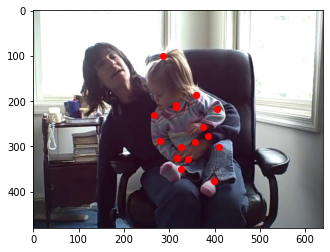

In [11]:
# Visualize a sample
image = plt.imread(os.path.join(IMAGE_PATH, sample.source_image))
# Basic Plot
fig, ax = plt.subplots()
im = ax.imshow(image)
ax.scatter([j.x for j in sample.joints], [j.y for j in sample.joints],color='red')
plt.show()

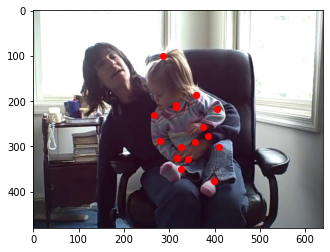

In [12]:
# Equivalent result with custom function
plot_datapoint(sample, mode="dots")

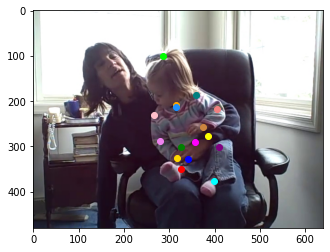

In [13]:
# Identify Joints with color convention
plot_datapoint(sample, mode="joints")

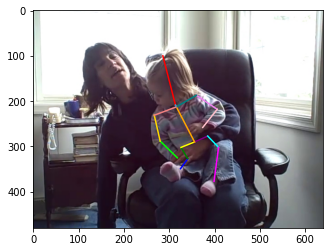

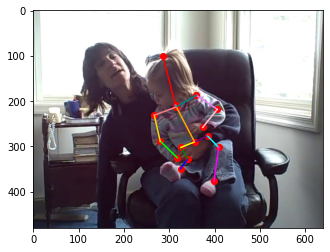

In [14]:
# Identify Joints with color convention
plot_datapoint(sample, mode="limbs")
plot_datapoint(sample, mode="limbs+dots")

### Prepare Records

We need to prepare the data where each record is a list of relevant information. For our purpose, we will use the following fields `source_image`, `bbox`, `joints`, `center`, `scale` to produce a table like array

Headers:
- Static columns *(8 columns)*
    - `source_image` Image to retrieve
      - Needed to load the input image
    - `scale` Scale of the person on the image
      - Needed to filter image where the person might be too small
    - `bbox_tl_x` Top Left BBox Corner X Coordinate
    - `bbox_tl_y` Top Left BBox Corner Y Coordinate
    - `bbox_br_x` Bottom Right BBox Corner X Coordinate
    - `bbox_br_y` Bottom Right BBox Corner Y Coordinate
    - `center_x`  Person Center X Coordinate
    - `center_y`  Person Center Y Coordinate
- Dynamic columns *(3 x NUM_JOINTS)*
  - `joint_{JOINT_ID}_x` Joint n°JOINT_ID X Coordinate
  - `joint_{JOINT_ID}_y` Joint n°JOINT_ID Y Coordinate
  - `joint_{JOINT_ID}_visible` Joint n°JOINT_ID Visibility as 0/1 flag
  - ...

For the MPII dataset given 16 joints we will generate a `(8 + 16 x 3) = 56 columns` table

In [15]:
# Ensure datapoints' joints are in dict format
_ = [datapoint.convert_joint(dict) for datapoint in htf_obj]
# Now the 'joints' property is a dictionary
sample.joints

{6: HTFPersonJoint(x=356, y=290, id=6, visible=True),
 7: HTFPersonJoint(x=314, y=209, id=7, visible=True),
 8: HTFPersonJoint(x=315, y=213, id=8, visible=False),
 9: HTFPersonJoint(x=286, y=100, id=9, visible=False),
 0: HTFPersonJoint(x=325, y=349, id=0, visible=True),
 1: HTFPersonJoint(x=341, y=327, id=1, visible=True),
 2: HTFPersonJoint(x=326, y=302, id=2, visible=True),
 3: HTFPersonJoint(x=385, y=277, id=3, visible=True),
 4: HTFPersonJoint(x=409, y=302, id=4, visible=True),
 5: HTFPersonJoint(x=399, y=377, id=5, visible=True),
 10: HTFPersonJoint(x=318, y=325, id=10, visible=True),
 11: HTFPersonJoint(x=280, y=288, id=11, visible=True),
 12: HTFPersonJoint(x=267, y=231, id=12, visible=True),
 13: HTFPersonJoint(x=360, y=187, id=13, visible=True),
 14: HTFPersonJoint(x=406, y=218, id=14, visible=True),
 15: HTFPersonJoint(x=374, y=258, id=15, visible=True)}

We define a `prepare_datapoint`as follow to generate such table:

In [16]:
def prepare_datapoint(datapoint: HTFPersonDatapoint):
    return [
        *[
            datapoint.source_image,
            datapoint.scale,
            datapoint.bbox.top_left.x,
            datapoint.bbox.top_left.y,
            datapoint.bbox.bottom_right.x,
            datapoint.bbox.bottom_right.y,
            datapoint.center.x,
            datapoint.center.y,
        ],
        *itertools.chain(*[
            [
                datapoint.joints.get(index).x if index in datapoint.joints else None,
                datapoint.joints.get(index).y if index in datapoint.joints else None,
                int(datapoint.joints.get(index).visible) if index in datapoint.joints else None,
            ]
            for index in range(NUM_JOINTS)
        ])
    ]

In [17]:
# We generate the dataset
table_dataset = [prepare_datapoint(datapoint) for datapoint in htf_obj]
array_dataset = np.array(table_dataset)
# Print Shape
print("Dataset shape", array_dataset.shape)

Dataset shape (28883, 56)


**WARNING: Data Leakage**

Obviously we will need to split this sample in a sub train/validation datasets. We could use a basic 80/20 random selection on the whole dataset, but we do not advise this approach as it might lead to data leakage. Indeed, many samples share the same image *(e.g 2 different person on the same image)*. To avoid this we will apply a random 80/20 selection on the source image to avoid this issue

You need to be aware that the number of image do not represent exactly the sample size of your subsets since multiple person might be display on a single image

In [18]:
print("Image number having sufficient data:", len(set(array_dataset[:, 0])))
print("Estimated image on train set:", int(0.8*len(set(array_dataset[:, 0]))))
print("Estimated image on validation set:", int(0.2*len(set(array_dataset[:, 0]))))

Image number having sufficient data: 17408
Estimated image on train set: 13926
Estimated image on validation set: 3481


In [19]:
image_names = set(array_dataset[:, 0])

In [20]:
# We sample images for Train Set
train_images = random.sample(image_names, int(0.7*(len(image_names))))
test_val_images = {image for image in image_names if image not in train_images}
test_image = random.sample(test_val_images, int(0.5*(len(test_val_images))))
# We Check images are selected only one time
print("Sizes valid:", len(train_images) == len(set(train_images)))
# We select the index
train_idx = np.isin(array_dataset[:, 0], train_images)
test_idx = np.isin(array_dataset[:, 0], test_image)
train_test_idx = np.logical_or(train_idx, test_idx)
validation_idx = np.logical_not(train_test_idx)
# Generate Sets
train_array = array_dataset[train_idx]
test_array = array_dataset[test_idx]
validation_array = array_dataset[validation_idx]
print("Train Set Size", train_array.shape)
print("Test Set Size", test_array.shape)
print("Validation Set Size", validation_array.shape)


/var/folders/yt/n2trg5vn7q1gldwvjlgl8gc00000gn/T/ipykernel_74185/3189832025.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_images = random.sample(image_names, int(0.7*(len(image_names))))
/var/folders/yt/n2trg5vn7q1gldwvjlgl8gc00000gn/T/ipykernel_74185/3189832025.py:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_image = random.sample(test_val_images, int(0.5*(len(test_val_images))))


Sizes valid: True
Train Set Size (20168, 56)
Test Set Size (4347, 56)
Validation Set Size (4368, 56)


In [21]:
# Compute Headers
headers = [
    *[
        'image',
        'scale',
        'bbox_tl_x',
        'bbox_tl_y',
        'bbox_br_x',
        'bbox_br_y',
        'center_x',
        'center_y',
        
    ],
    *itertools.chain(*[(f"joint_{i}_X", f"joint_{i}_Y", f"joint_{i}_visible") for i in range(NUM_JOINTS)])
]
# Visualize as DataFrame 
train_df = pd.DataFrame.from_records(train_array, columns=headers)
test_df = pd.DataFrame.from_records(test_array, columns=headers)
validation_df = pd.DataFrame.from_records(validation_array, columns=headers)

In [22]:
def sanitize_dataset(df: pd.DataFrame):
    # Convert Coordinates as Int and fill NaN values with -1
    df[
        list(itertools.chain(*[ [f"joint_{i}_X", f"joint_{i}_Y"] for i in range(NUM_JOINTS)]))
    ] = df.filter(
        itertools.chain(*[ [f"joint_{i}_X", f"joint_{i}_Y"] for i in range(NUM_JOINTS)])
    ).fillna(-1).astype(int)
    # Fill NaN visibility values with 0 and Cast as Int
    df[
        [f"joint_{i}_visible" for i in range(NUM_JOINTS)]
    ] = df.filter(
        [f"joint_{i}_visible" for i in range(NUM_JOINTS)]
    ).fillna(0).astype(int)
    return df

In [23]:
sanitize_train_df = sanitize_dataset(train_df)
sanitize_test_df = sanitize_dataset(test_df)
sanitize_validation_df = sanitize_dataset(validation_df)
sanitize_train_df

,image,scale,bbox_tl_x,bbox_tl_y,bbox_br_x,bbox_br_y,center_x,center_y,joint_0_X,joint_0_Y,...,joint_12_visible,joint_13_X,joint_13_Y,joint_13_visible,joint_14_X,joint_14_Y,joint_14_visible,joint_15_X,joint_15_Y,joint_15_visible
0,015601864.jpg,3.021046,627,627,706,706,594,257,620,394,...,1,692,185,1,693,240,1,688,313,1
1,015601864.jpg,2.472117,841,841,902,902,952,222,895,293,...,0,924,206,1,1013,203,1,955,263,1
2,015599452.jpg,5.641276,607,607,752,752,619,329,-1,-1,...,0,719,299,1,711,516,1,545,466,1
3,015599452.jpg,6.071051,903,903,1070,1070,1010,412,-1,-1,...,1,1145,269,1,1226,475,1,1096,433,1
4,015599452.jpg,5.728162,27,27,186,186,133,315,-1,-1,...,1,26,251,1,26,423,1,-1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20163,028705661.jpg,3.806403,144,144,239,239,215,257,-1,-1,...,1,199,194,0,225,277,0,295,271,1
20164,050240222.jpg,3.480000,543,543,630,630,643,321,607,689,...,1,663,228,1,623,289,1,555,333,1
20165,033474347.jpg,2.003677,622,622,679,679,737,286,876,461,...,0,663,223,1,674,286,1,631,260,1
20166,082650067.jpg,3.235820,686,686,773,773,851,363,1038,656,...,0,729,220,1,704,332,1,675,269,1


This notebook is only for demonstration purpose, but this methodology is the one applied to train the model. Once frozen, the train/validation image list will be used as Model Metadata to ensure which image as been seen by the neural network during training. The next step would be to export the given set and use it to build a `tf.Dataset`. The next notebook will tackle this step

In [24]:
sanitize_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20168 entries, 0 to 20167
Data columns (total 56 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             20168 non-null  object 
 1   scale             20168 non-null  float64
 2   bbox_tl_x         20168 non-null  int64  
 3   bbox_tl_y         20168 non-null  int64  
 4   bbox_br_x         20168 non-null  int64  
 5   bbox_br_y         20168 non-null  int64  
 6   center_x          20168 non-null  int64  
 7   center_y          20168 non-null  int64  
 8   joint_0_X         20168 non-null  int64  
 9   joint_0_Y         20168 non-null  int64  
 10  joint_0_visible   20168 non-null  int64  
 11  joint_1_X         20168 non-null  int64  
 12  joint_1_Y         20168 non-null  int64  
 13  joint_1_visible   20168 non-null  int64  
 14  joint_2_X         20168 non-null  int64  
 15  joint_2_Y         20168 non-null  int64  
 16  joint_2_visible   20168 non-null  int64 

### Export Records

In [25]:
sanitize_train_df['set'] = 'TRAIN'
sanitize_test_df['set'] = 'TEST'
sanitize_validation_df['set'] = 'VALIDATION'
export_df = pd.concat(
    [sanitize_train_df, sanitize_test_df, sanitize_validation_df]
)
print(export_df.set.value_counts())
export_df.to_csv(os.path.join(ROOT_FOLDER, "data", "labels.ignore.csv"), index=False)
export_df.to_json(os.path.join(ROOT_FOLDER, "data", "labels.ignore.json"), orient='records')
export_df

TRAIN         20168
VALIDATION     4368
TEST           4347
Name: set, dtype: int64


,image,scale,bbox_tl_x,bbox_tl_y,bbox_br_x,bbox_br_y,center_x,center_y,joint_0_X,joint_0_Y,...,joint_13_X,joint_13_Y,joint_13_visible,joint_14_X,joint_14_Y,joint_14_visible,joint_15_X,joint_15_Y,joint_15_visible,set
0,015601864.jpg,3.021046,627,627,706,706,594,257,620,394,...,692,185,1,693,240,1,688,313,1,TRAIN
1,015601864.jpg,2.472117,841,841,902,902,952,222,895,293,...,924,206,1,1013,203,1,955,263,1,TRAIN
2,015599452.jpg,5.641276,607,607,752,752,619,329,-1,-1,...,719,299,1,711,516,1,545,466,1,TRAIN
3,015599452.jpg,6.071051,903,903,1070,1070,1010,412,-1,-1,...,1145,269,1,1226,475,1,1096,433,1,TRAIN
4,015599452.jpg,5.728162,27,27,186,186,133,315,-1,-1,...,26,251,1,26,423,1,-1,-1,0,TRAIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,050355215.jpg,4.992923,870,870,998,998,873,504,981,815,...,873,262,0,867,419,0,993,446,0,VALIDATION
4364,026824269.jpg,2.931539,930,930,1008,1008,998,289,955,669,...,1016,150,1,1026,256,1,938,252,1,VALIDATION
4365,082055973.jpg,2.577962,892,892,955,955,925,382,917,655,...,910,233,0,897,310,0,963,324,1,VALIDATION
4366,087119644.jpg,2.088000,890,890,950,950,881,518,968,760,...,841,386,1,813,466,1,866,469,0,VALIDATION
